In [1]:
from pyNA.pyna import pyna
import openmdao.api as om
import numpy as np

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
settings = dict()

settings['ac_name'] = 'stca'
settings['engine_deck_file_name'] = 'engine_deck_stca.csv'
settings['output_directory_name'] = '.'
settings['time_history_file_name'] = 'time_history.csv'
settings['output_file_name'] = 'trajectory.sql'

settings['n_frequency_bands'] = 24
settings['n_frequency_subbands'] = 5
settings['fan_inlet_source'] = True
settings['fan_discharge_source'] = True
settings['core_source'] = True
settings['jet_mixing_source'] = True
settings['jet_shock_source'] = True
settings['airframe_source'] = True
settings['core_turbine_attenuation_method'] = 'ge'
settings['atmosphere_mode'] = 'stratified'
settings['thrust_lapse'] = True
settings['F00'] = None

settings['noise'] = False
settings['emissions'] = False

settings['pkrot'] = True

settings['tolerance'] = 1e-4
settings['max_iter'] = 100
settings['atmosphere_dT'] = 10.0699

settings['save_results'] = False


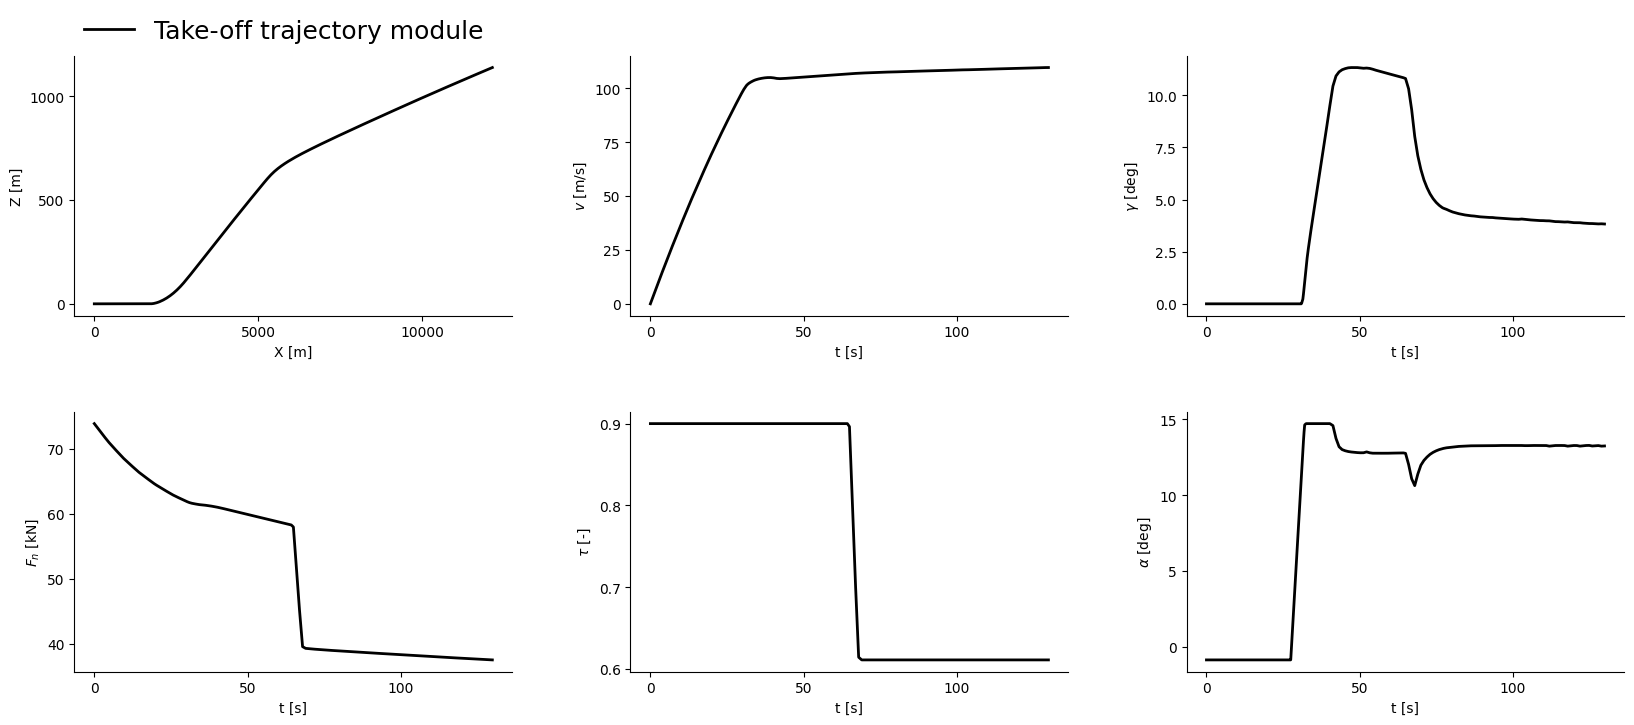

In [3]:
settings['case_name'] = 'nasa_stca_standard'
py_stca = pyna(settings=settings, trajectory_mode='data')
py_stca.trajectory.solve(py_stca.settings)
py_stca.plot_trajectory()

In [4]:
settings['case_name'] = 'stca'
settings['z_cb'] = py_stca.trajectory.path.get_val('z')[np.where(py_stca.trajectory.path.get_val('tau') < 0.65)[0][0]]
settings['v_max'] = py_stca.trajectory.path.get_val('v')[-1]

py = pyna(settings=settings, trajectory_mode='model')

tau={'groundroll':0.88, 'rotation':0.88, 'liftoff':0.88, 'vnrs':0.88, 'cutback':0.61}
theta_flaps={'groundroll':10., 'rotation':10., 'liftoff':10., 'vnrs':10., 'cutback':10.}
theta_slats={'groundroll':-6., 'rotation':-6., 'liftoff':-6., 'vnrs':-6., 'cutback':-6.}
k_rot=1.27

py.trajectory.solve(py.settings, py.aircraft, tau=tau, theta_flaps=theta_flaps, theta_slats=theta_slats, k_rot=k_rot)

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/utils/options_dictionary.py:332: OMDeprecationWarning:'gradient method' is not a valid python name and will become an invalid option name in a future release. You can prevent this warning (and future exceptions) by declaring this option using a valid python name.


--- Linkage Report [phases] ---
    --- groundroll - rotation ---
        time               [final] ==  time           [initial]
        states:x           [final] ==  states:x       [initial]
        states:v           [final] ==  states:v       [initial]
        parameters:alpha   [final*] ==  states:alpha   [initial]
    --- rotation - liftoff ---
        time               [final] ==  time             [initial]
        states:x           [final] ==  states:x         [initial]
        parameters:z       [final*] ==  states:z         [initial]
        states:v           [final] ==  states:v         [initial]
        states:alpha       [final] ==  controls:alpha   [initial]
        parameters:gamma   [final*] ==  states:gamma     [initial]
    --- liftoff - vnrs ---
        time             [final] ==  time             [initial]
        states:x         [final] ==  states:x         [initial]
        states:v         [final] ==  states:v         [initial]
        controls:alpha   [fin

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, dymos_solution.db, is being overwritten.


Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Full total jacobian was computed 3 times, taking 4.593821 seconds.
Total jacobian shape: (247, 169) 


Jacobian shape: (247, 169)  ( 3.91% nonzero)
FWD solves: 11   REV solves: 0
Total colors vs. total size: 11 vs 169  (93.5% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity: 4.593821 sec.
Time to compute coloring: 0.217083 sec.


Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    8.1226
       User Objective Time :       0.7223
       User Sensitivity Time :     6.3843
       Interface Time :            0.9098
       Opt Solver Time:            0.1062
    Calls to Objective Function :      22
    Calls to Sens Function :           21


   Objectives
     

Converged: True


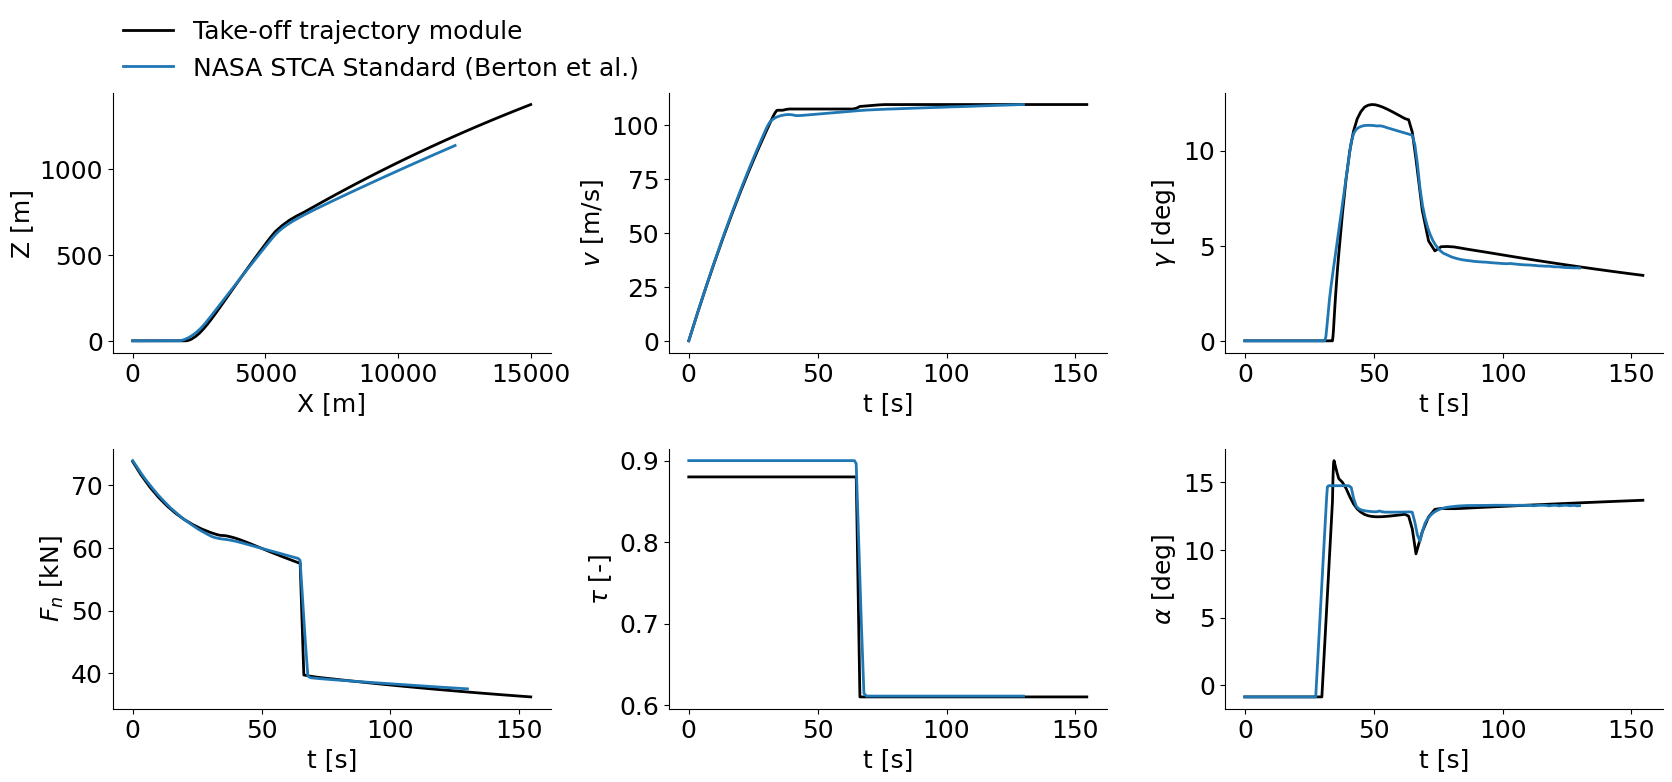

In [5]:
py.plot_trajectory(paths_compare=[py_stca.trajectory.path], labels_compare=['NASA STCA Standard (Berton et al.)'])

In [6]:
om.n2(py.trajectory.path)